In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler
import seaborn as sns
from scipy.stats import norm, lognorm

In [2]:
sns.set_theme()
beta_true = 0.15
alpha = 0.1
gamma = 0.0
prior_mu = -3
prior_sigma = 1
n_zones = 1
N = 100
T = 52
K = 30

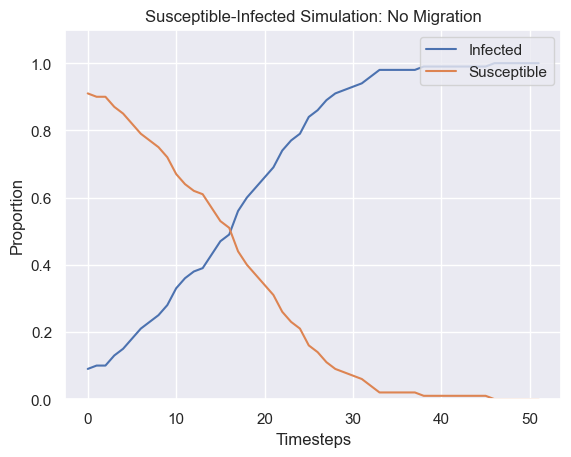

In [3]:
si_model = SIModel(alpha, gamma, beta_true, n_zones,
                   prior_mu, prior_sigma, 
                   N, T, summarize=False)
x_o_raw = si_model.get_observed_data(29)
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Infected")
plt.plot(S_o, label="Susceptible")
plt.legend(loc="upper right")
plt.xlabel("Timesteps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.title("Susceptible-Infected Simulation: No Migration")
plt.show()

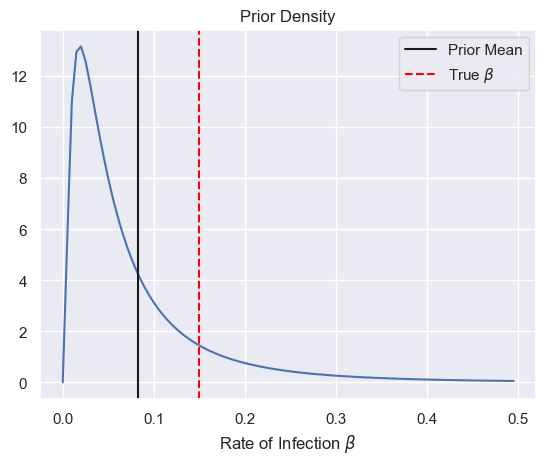

In [9]:
# visualize prior
np.random.seed(10)
x = np.arange(0, 0.5, 0.005)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma))
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(f"Prior Density")
prior_mean = np.exp(prior_mu + prior_sigma**2/2)
plt.axvline(prior_mean, color="k", label="Prior Mean")
plt.axvline(beta_true, color="red", linestyle="--", label=r"True $\beta$")
plt.legend()
plt.show()

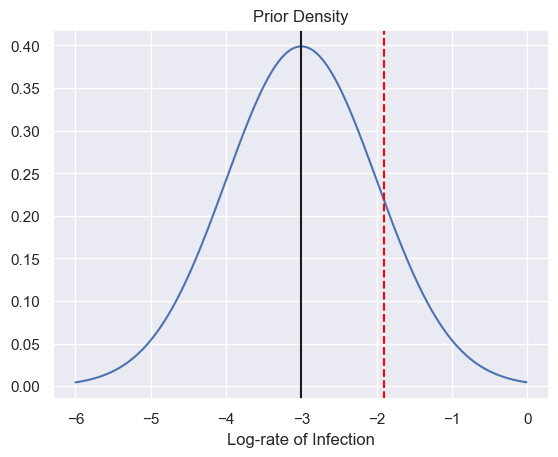

In [8]:
np.random.seed(10)
x = np.arange(-6, 0, 0.01)
ax = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma))
ax.set_xlabel("Log-rate of Infection")
ax.set_title(f"Prior Density")
plt.axvline(prior_mu, color="k")
plt.axvline(np.log(beta_true), color="red", linestyle="--")
plt.show()

A reasonably well-calibrated prior: $P(\beta > \beta^*) = 0.15$.

### Prior Predictive Check

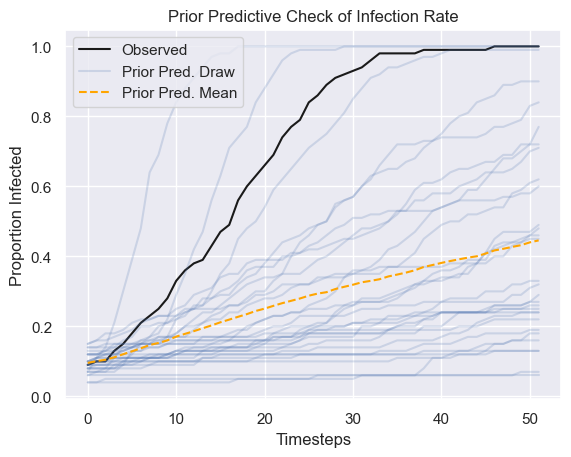

In [32]:
prior = norm(prior_mu, prior_sigma)
prior_sample = np.exp(prior.rvs(size=K, random_state=2))
prior_predictive = np.empty((K, T))

for i in range(K):
    si_model = SIModel(alpha, gamma, prior_sample[i],
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    prior_predictive[i] =  np.array(x_rep)[0]
prp_mean = prior_predictive.mean(0)

labels = ["Prior Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(prior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(prp_mean, label="Prior Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Prior Predictive Check of Infection Rate")
plt.ylabel("Proportion Infected")
plt.xlabel("Timesteps")
plt.show()

## ABC

#### Raw Data

Time lapsed: 2.69 seconds
With tolerance 0.002, acceptance rate: 0.030798
Total number of attempts: 3,247


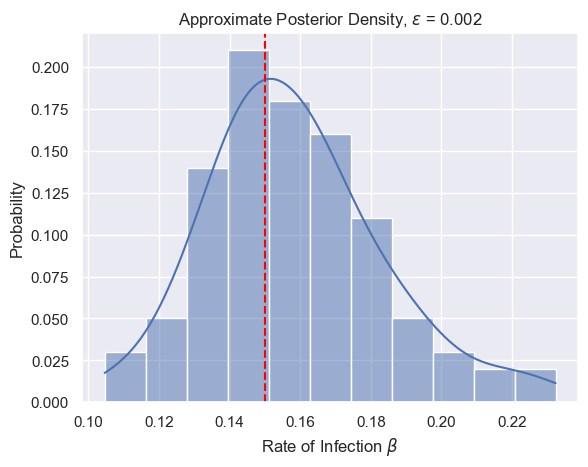

In [14]:
summarize = False
si_model = SIModel(alpha, gamma, beta_true, 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)
if not summarize:
    x_o = x_o.transpose(0, 1)
S = 100
epsilon = 0.002
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, 
    max_attempts=20000, summarize=summarize
    )
ax = sns.histplot(np.exp(posterior_sample), stat="probability", kde=True)
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(rf"Approximate Posterior Density, $\epsilon$ = {epsilon}")
plt.axvline(beta_true, color="red", linestyle="--")
ax.get_legend().remove()
plt.show()

#### Summary Statistic

Time lapsed: 1.83 seconds
With tolerance 0.001, acceptance rate: 0.046577
Total number of attempts: 2,147


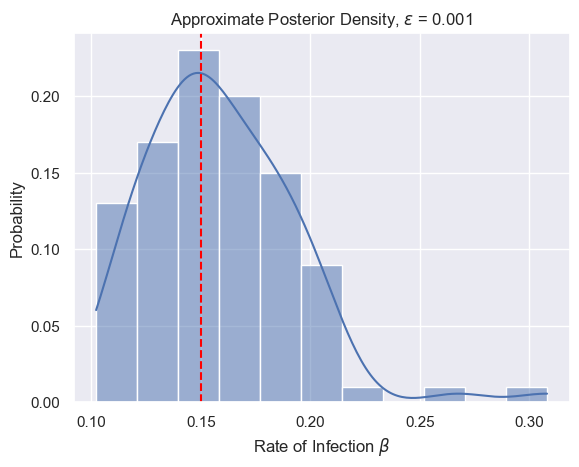

In [15]:
summarize = True
si_model = SIModel(alpha, gamma, beta_true, 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)
if not summarize:
    x_o = x_o.transpose(0, 1)

S = 100
epsilon = 0.001
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, 
    max_attempts=20000, summarize=summarize
    )
ax = sns.histplot(np.exp(posterior_sample), stat="probability", kde=True)
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(rf"Approximate Posterior Density, $\epsilon$ = {epsilon}")
plt.axvline(beta_true, color="red", linestyle="--")
ax.get_legend().remove()
plt.show()

### NPE

#### raw data!

Hyperparameters: 256 observations, network dimension 32, 300 training epochs

roughly: 1/4 of the data needed

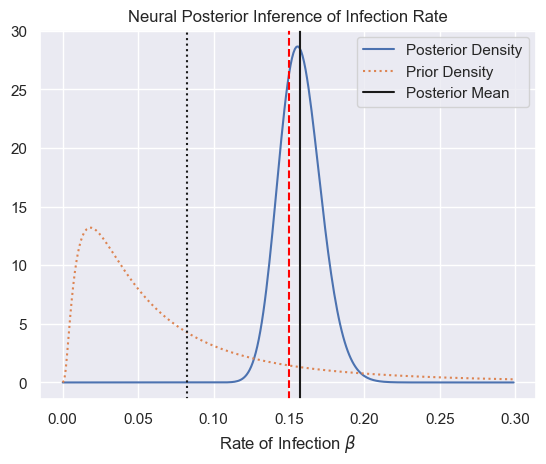

In [22]:
mu = -1.852 # -1.907 aka .157
sigma = 0.089 # .106
np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(f"Neural Posterior Inference of Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":")
plt.axvline(posterior_mean, color="k", label="Posterior Mean")
plt.axvline(beta_true, color="red", linestyle="--")
plt.legend()
plt.show()

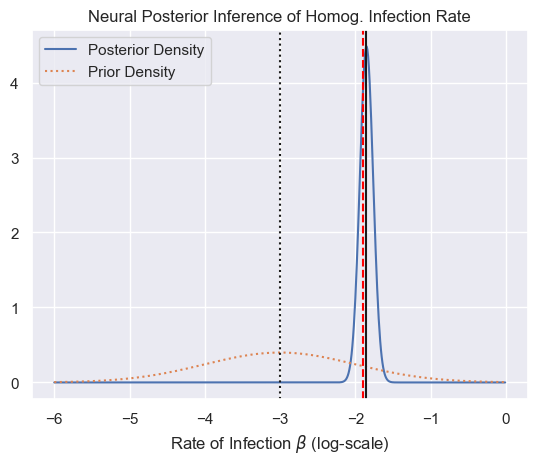

In [34]:
np.random.seed(10)
x = np.arange(-6., 0, 0.01)
ax = sns.lineplot(x=x, y=norm.pdf(x, mu, sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=norm.pdf(x, prior_mu, prior_sigma), 
                   label="Prior Density", linestyle=":")
ax.set_xlabel(r"Rate of Infection $\beta$ (log-scale)")
ax.set_title(f"Neural Posterior Inference of Homog. Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mu, color="k", linestyle=":")
plt.axvline(mu, color="k")
plt.axvline(np.log(beta_true), color="red", linestyle="--", label="True")
plt.show()

## Posterior Predictive Checks

In [26]:
neural_posterior = norm(mu, sigma)
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))


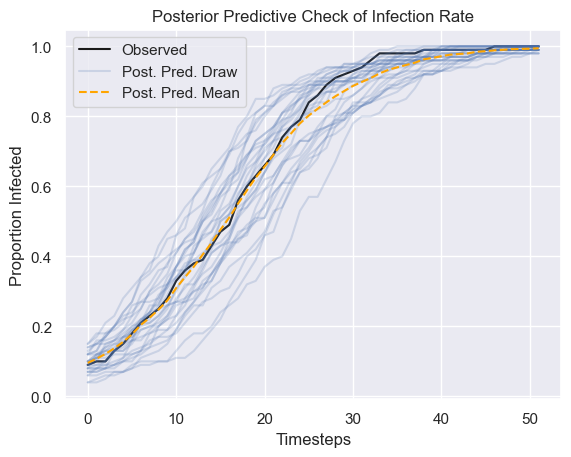

In [33]:
for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate")
plt.xlabel("Timesteps")
plt.ylabel("Proportion Infected")
plt.show()

## Summary statistics

width 32, 256 samples, 300 training epochs as before

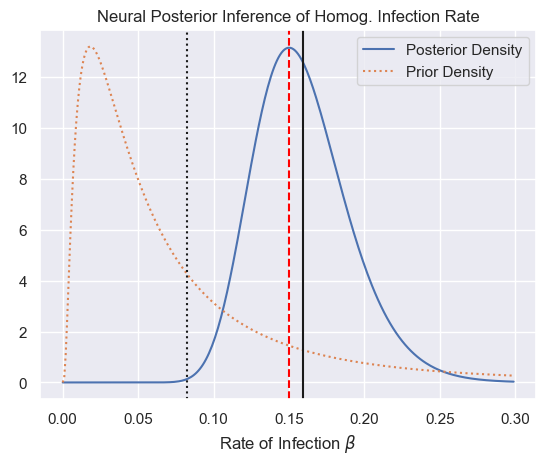

In [46]:
mu = -1.857 
sigma = 0.198
np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Posterior Density")
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
ax.set_xlabel(r"Rate of Infection $\beta$")
ax.set_title(f"Neural Posterior Inference of Homog. Infection Rate")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":")
plt.axvline(posterior_mean, color="k")
plt.axvline(beta_true, color="red", linestyle="--", label="True")
plt.show()

In [50]:
np.median(posterior_predictive, 0).shape

(52,)

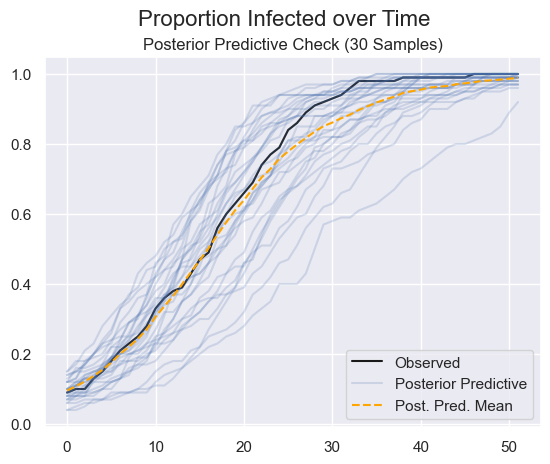

In [53]:
neural_posterior = norm(mu, sigma)
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))

for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   n_zones, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)
labels = ["Posterior Predictive"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.suptitle("Proportion Infected over Time", fontsize=16)
plt.title("Posterior Predictive Check (30 Samples)")
plt.show()

## Finding

Estimating NPE off of a summary statistic increase variance of the posterior estimate by a factor of 4!